# Base model and data collection

In [4]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 5.3 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=c4c4699a9e24bcbcd1a9832f331cf3a9d851c71d0037e2fa0adf3651feea131b
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty-midi


In [5]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pretty_midi as pm
import collections
from sklearn.preprocessing import RobustScaler, MinMaxScaler


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## data

### Load raw data

In [8]:
#Loading the list of chopin's midi files as stream 
filepath = os.path.join("drive", "MyDrive", "Colab Notebooks", "data", "raw_data", "chopin")
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = os.path.join(filepath, i)
        midi = pm.PrettyMIDI(tr)
        all_midis.append(midi)

In [9]:
def bpm(midi_file):
  """returns most frequent bpm listed in midi file"""
  l, counts = np.unique(midi_file.get_tempo_changes()[1].round(), return_counts=True)
  return l[np.argmax(counts)]

In [10]:
#Helping function        
def midi_to_notes(file) -> pd.DataFrame:
  """Turns midi file into dataframe containing 
  pitch, step, duration and velocity"""

  notes = collections.defaultdict(list)
  sorted_notes=[]
  for i in range(len(file.instruments)):
    # Sort the notes by start time
    sorted_notes += list(file.instruments[i].notes)

  sorted_notes = sorted(sorted_notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['start'].append(start)
    notes['pitch'].append(int(note.pitch))
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    notes['velocity'].append(note.velocity)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()}).sort_values(by=['start'])

In [11]:
def notes_to_chords(df):
  """group notes played at the same time into chords.
  returns dataframe with pitch, start and step columns"""

  df['pitch'] = df['pitch'].apply(lambda x: str(x))
  df = df.groupby('start', as_index=False).agg({'pitch':lambda x : '.'.join(x), 
                                                'step':'sum', 
                                                'velocity':'max', 
                                                'duration':'max'})
  return df

In [12]:
def strongest_note(df):
  """group notes played at the sametime based on the stongest note played. 
  returns dataframe with pitch, start and step columns"""

  df = df.groupby('start', as_index=False).agg({'pitch':(lambda g: g[df.loc[g.index]['velocity'].idxmax()]), 
                                                'step':'sum', 
                                                'velocity':'max', 
                                                'duration':'max'})
  return df

In [13]:
processed_files = [strongest_note(midi_to_notes(file)) for file in all_midis]

In [14]:
sample_files = pd.concat(processed_files).reset_index().drop(columns='index')

In [15]:
sample_files['pitch'] = sample_files['pitch']-21

In [16]:
sample_files.to_csv(os.path.join("..", "data", "processed_data", 
                                 "processed_data.csv"))

FileNotFoundError: ignored

### Load processed data

In [7]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/data/processed_data/processed_data.csv', index_col=0)

## Data exploration

In [19]:
data

,start,pitch,step,velocity,duration
0,0.001811,27,0.000000,90,2.171157
1,2.172967,30,2.171157,79,0.407942
2,2.580909,35,0.407942,83,0.389610
3,2.970519,37,0.389610,76,0.405406
4,3.375925,39,0.405406,83,0.387097
...,...,...,...,...,...
43471,26.031188,30,0.131796,32,0.129365
43472,26.160553,37,0.129365,34,0.134530
43473,26.295083,30,0.134530,30,0.149325
43474,26.444408,37,0.149325,29,0.216685


In [20]:
pitches = sample_files['pitch']

In [21]:
un_notes, counts = np.unique(pitches, return_counts=True)
print("Total unique notes in the Corpus:", un_notes.shape[0])

Total unique notes in the Corpus: 76


In [22]:
#Average recurrenc for a note in Corpus
def Average(array):
    return sum(array) / len(array)
print("Average recurrence for a note in Corpus:", Average(counts))
print("Most frequent note in Corpus appeared:", max(counts), "times")
print("Least frequent note in Corpus appeared:", min(counts), "times")

Average recurrence for a note in Corpus: 572.0526315789474
Most frequent note in Corpus appeared: 1760 times
Least frequent note in Corpus appeared: 4 times


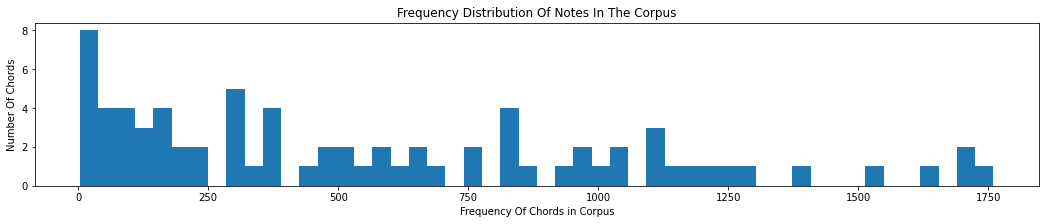

In [23]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3)) 
plt.hist(counts, bins=50)
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [24]:
#Getting a list of rare chords
        
print("Total number of notes that occur less than 10 times:", (counts<100).sum())

Total number of notes that occur less than 10 times: 16


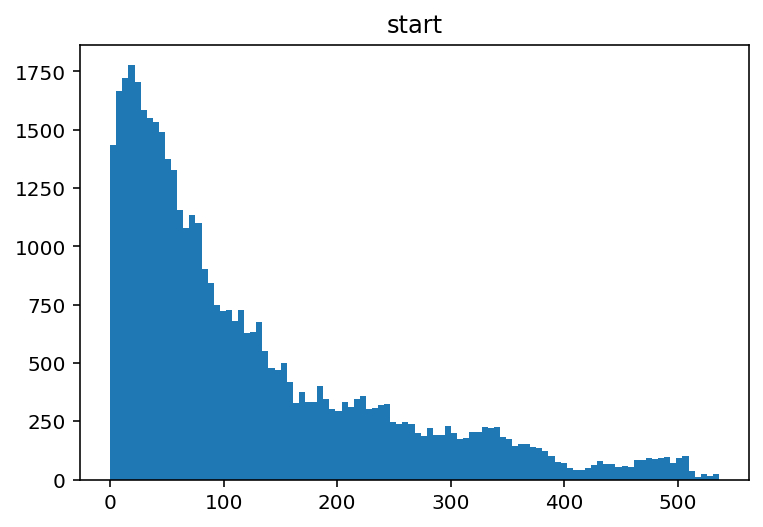

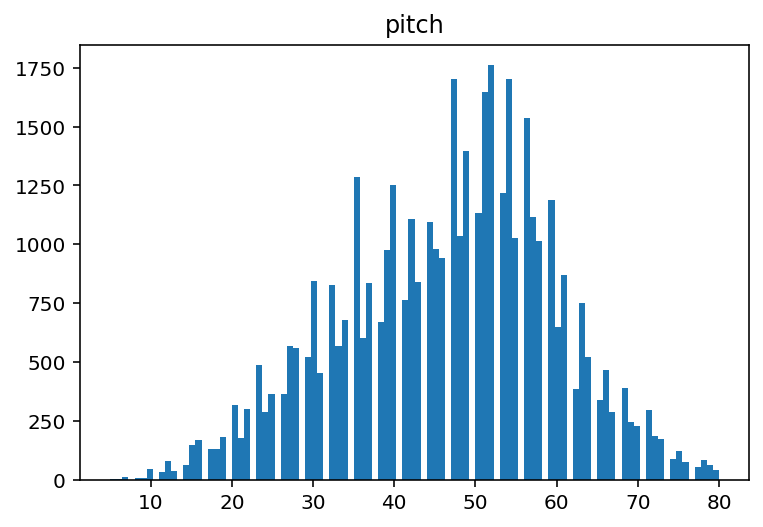

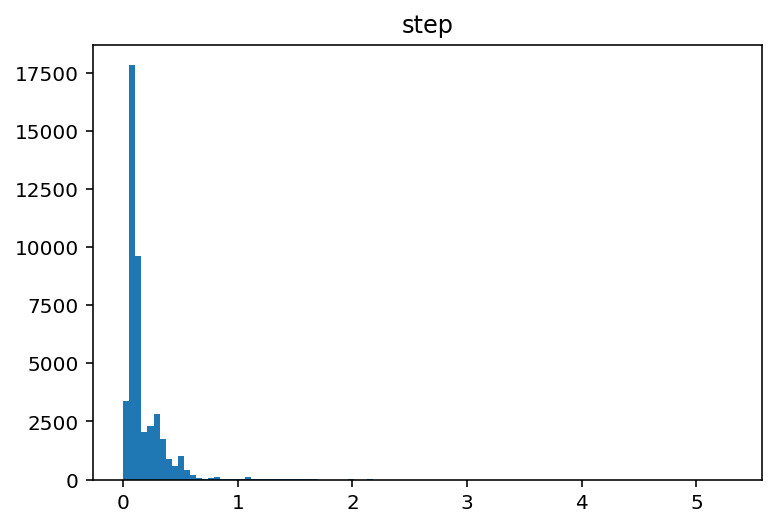

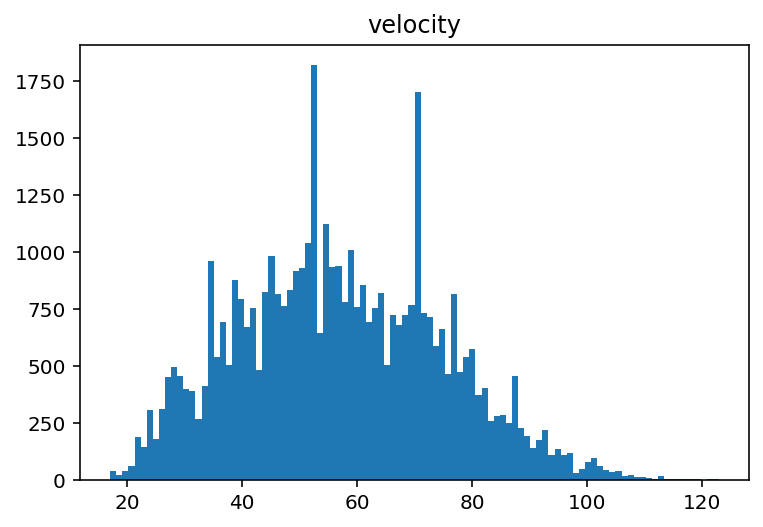

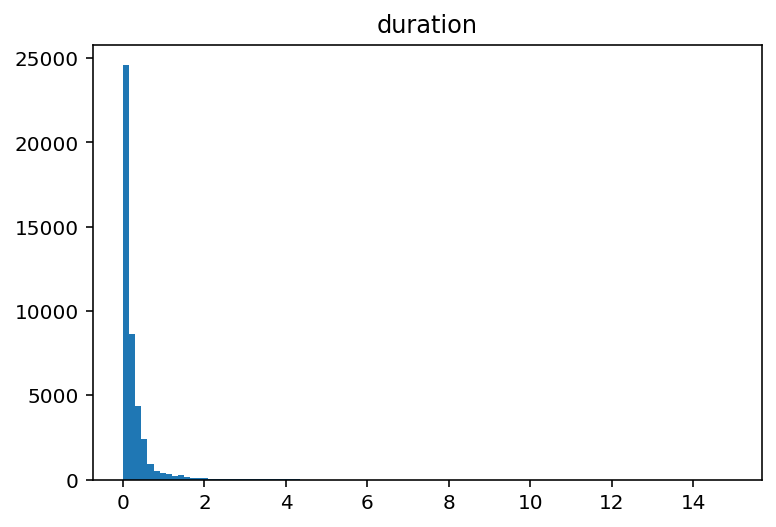

In [91]:
for col in data.columns:
  plt.hist(data[col], bins=100)
  plt.title(col)
  plt.show()

## Preprocessing

In [8]:
def data_split(df, 
               train_split=0.7, 
               val_split=0.2,
               seed_split=0.1,
               seq_length=40):
  """Function which takes a chronologically 
  ordered dataframe, desired sequence length,
  as well as train, validation, seed split sizes, 
  and returns train, validation and seed datasets. 
  (function ONLY works with input split
  sizes with one decimal place)"""

  num_seq = round(len(df)/(seq_length+1))
  train_df = pd.DataFrame(columns=df.columns)
  val_df = pd.DataFrame(columns=df.columns)
  seed_df = pd.DataFrame(columns=df.columns)

  for i, chunk in enumerate(np.array_split(df, num_seq)):
    if int(str(i)[-1]) < 10*train_split:
      train_df = pd.concat([train_df, chunk])
    elif int(str(i)[-1]) < 10*(train_split+val_split):
      val_df = pd.concat([val_df, chunk])
    else:
      seed_df = pd.concat([seed_df, chunk])

  train_df = train_df.reset_index().drop(columns='index').astype('float64')

  val_df = val_df.reset_index().drop(columns='index').astype('float64')

  seed_df = seed_df.reset_index().drop(columns='index').astype('float64')

  return train_df, val_df, seed_df

In [32]:
train_df, val_df, seed_df = data_split(data)

In [33]:
train_df.to_csv(os.path.join("drive", "MyDrive", "Colab Notebooks", "data", "processed_data", 
                             "processed_train.csv"))
val_df.to_csv(os.path.join("drive", "MyDrive", "Colab Notebooks", "data", "processed_data", 
                           "processed_val.csv"))
seed_df.to_csv(os.path.join("drive", "My Drive", "Colab Notebooks", "data", "processed_data", 
                            "processed_seed.csv"))

In [34]:
cols = ['pitch', 'step', 'duration', 'velocity']

In [35]:
def df_to_dataset(df: pd.DataFrame):
  """Transforms a dataframe into a Tensorflow dataset"""
  
  dataset = np.stack([df[col] for col in cols], axis=1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)

  return dataset

In [36]:
train_notes, val_notes, seed_notes = df_to_dataset(train_df), df_to_dataset(val_df), df_to_dataset(seed_df)

In [37]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int = 40,
    shift: int=3
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=shift, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(cols)}

    return inputs, labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [38]:
train_seq_ds = create_sequences(train_notes)

val_seq_ds = create_sequences(val_notes)

seed_seq_ds = create_sequences(seed_notes)

In [39]:
def create_batches(sequences,
                   batch_size: int=128):
  """Returns batched dataset for more efficient 
  data extraction during model training."""

  ds = (sequences
        .batch(batch_size, drop_remainder=True)
        .cache()
        .prefetch(tf.data.experimental.AUTOTUNE))
  return ds

In [40]:
train_ds = create_batches(train_seq_ds)

val_ds = create_batches(val_seq_ds)

seed_ds = create_batches(seed_seq_ds)

## Model

In [41]:
def instantiate_model(seq_length: int=40):
    """instantiate RNN model"""

    input_shape = (seq_length, len(cols))

    inputs = tf.keras.Input(input_shape)
    model = LSTM(512, return_sequences=True)(inputs)

    model = Dropout(0.1)(model)
    model = LSTM(256)(model)
    model = Dropout(0.3)(model)
    model = Dense(64)(model)
    model = Dropout(0.4)(model)
    model = Dense(32)(model)
    model = Dropout(0.5)(model)
    outputs = {'pitch': Dense(88, name='pitch', activation='softmax')(model)}
    for col in cols[1:]:
        outputs[col] = Dense(1, name=col)(model)

    model = tf.keras.Model(inputs, outputs)

    return model

In [42]:
model = instantiate_model()

In [ ]:
tf.keras.utils.plot_model(model, 'a.png', show_shapes=True)

In [43]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [44]:
metrics = {'pitch': 'accuracy'}

for col in cols[1:]:
    metrics[col] = 'mse'


loss = {'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}

for col in cols[1:]:
    loss[col] = mse_with_positive_pressure

In [45]:
model.compile(
    loss=loss,
    optimizer='rmsprop',
    metrics=metrics
)

In [46]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
        EarlyStopping(monitor='loss',
                      patience=10,
                      verbose=0,
                      restore_best_weights=True),
]

In [ ]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data = val_ds
)

In [28]:
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.show()

NameError: ignored

### Prediction

In [67]:
def adjust_step(step: float):
  """Turns numerical step into musical 1/1->1/32 step"""
  timestamps = [2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]
  return min(timestamps, key=lambda x:abs(x-step))

In [54]:
def predict_notes(
    notes: pd.DataFrame, 
    model: tf.keras.Model, 
    temperature: float = 1.0, 
    num_predictions: int=150,
    seq_length: int=40) -> pd.DataFrame:
    """Generates n following notes as a dataframe."""
    
    array = np.zeros(len(cols))
    array[0]=21
    input_notes = (np.stack([notes[key] for key in cols], axis=1) - array)[-seq_length:]
    generated_notes = []
    prev_start = 0
    for _ in range(num_predictions):
        input_notes = tf.expand_dims(input_notes, 0)
        predictions = model.predict(input_notes, verbose=0)
        pitch_logits = predictions['pitch']

        pitch_logits /= temperature
        pitch = tf.random.categorical(pitch_logits, num_samples=1)
        pitch = tf.squeeze(pitch, axis=-1)

        input_note = [np.array(pitch)[0]]
        for col in cols[1:]:
            attr = tf.maximum(0, tf.squeeze(predictions[col], axis=-1))
            input_note.append(np.array(attr)[0])
            
        generated_notes.append(input_note)
        input_notes = np.delete(np.squeeze(input_notes, 0), 0, axis=0)

        input_notes = np.append(input_notes, np.array(input_note, ndmin=2), axis=0)

    generated_notes = pd.DataFrame(
      generated_notes, columns=cols)
    
    if 'step' in cols:
      generated_notes['step'] = generated_notes['step'].map(lambda x: adjust_step(x))

    return generated_notes

In [55]:
pred = predict_notes(seed_df, model)

## Audio file

In [60]:
def notes_to_midi(
  notes: pd.DataFrame,
) -> pm.PrettyMIDI:

  p = pm.PrettyMIDI()
  instrument = pm.Instrument(program=pm.instrument_name_to_program('Acoustic Grand Piano'))
  
  prev_start = 0
  for i, note in notes.iterrows():
    if 'step' in cols:
        start = float(prev_start + note['step'])
    else:
        start = float(prev_start + 0.17)
        
    if 'duratio' in cols:
        end = float(start + note['duration'])
    else:
        end = float(start + 0.27)
        
    if 'velocity' in cols:
        velocity = int(note['velocity'])
    else:
        velocity = 57
    
    note = pm.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end
    )
    instrument.notes.append(note)
    prev_start = start

  p.instruments.append(instrument)
  p.write('file.mid')
  return p

In [63]:
p = notes_to_midi(pred)

In [62]:
pred

,pitch,step,duration,velocity
0,22,0.03125,0.0,0.000000
1,44,0.03125,0.0,0.000000
2,37,0.03125,0.0,0.000000
3,59,0.03125,0.0,0.000000
4,75,0.25000,0.0,0.000000
...,...,...,...,...
145,66,0.25000,0.0,0.040336
146,53,0.25000,0.0,0.045886
147,80,0.25000,0.0,0.049519
148,62,0.25000,0.0,0.045654
